In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [235]:
maxEvents = 2000000
#maxEvents = 500000
#maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.55, 1.7, 1.8, 1.98, 2.15, 2.4)
eta_bins = eta_bins[::-1]
#pt_bins = (-0.5 , -0.38, -0.26, -0.15, -0.05, 0.05, 0.15, 0.26, 0.38, 0.5)
pt_bins = (-0.5 , -0.333333, -0.24, -0.15, -0.07, 0.07, 0.15, 0.24, 0.333333, 0.5)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)
superstrip_size = 32

assert(len(eta_bins) == 6+1)
assert(len(pt_bins) == 9+1)

from six.moves import range, zip, map, filter

from incrementalstats import IncrementalStats

def find_sector(phi):  # phi in radians
  dphi = delta_phi(phi, np.pi/12)  # sector 1 starts at 15 deg
  dphi = int(np.floor(dphi/(np.pi/3)))  # divide by 60 deg
  if dphi < 0:
    sector = 7 + dphi
  else:
    sector = 1 + dphi
  return sector

def find_endcap(eta):
  endcap = +1 if eta >= 0. else -1
  return endcap

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def _find_bin_fast(x, bins):
  x = np.clip(x, bins[1], bins[2]-1e-7)
  binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
  return int(binx)

def find_eta_bin_12(eta, bins=(12,1.2,2.4)):
  return _find_bin_fast(abs(eta), bins)

def find_pt_bin_100(pt, bins=(100,-0.5,0.5)):
  return _find_bin_fast(pt, bins)

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,2,2] = 6  # RE2/2
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    return entry

find_emtf_layer = EMTFLayer()

# Decide EMTF hit zones
class EMTFZone(object):
  def __init__(self):
    lut = np.zeros((5,5,5,6,2), dtype=np.int32) - 99  # (type, station, ring) -> [zone] x [min_theta,max_theta]
    lut[1,1,4][0] = 4,17   # ME1/1a
    lut[1,1,4][1] = 16,26  # ME1/1a
    lut[1,1,4][2] = 24,37  # ME1/1a
    lut[1,1,4][3] = 34,43  # ME1/1a
    lut[1,1,4][4] = 40,53  # ME1/1a
    lut[1,1,1][0] = 4,17   # ME1/1b
    lut[1,1,1][1] = 16,26  # ME1/1b
    lut[1,1,1][2] = 24,37  # ME1/1b
    lut[1,1,1][3] = 34,43  # ME1/1b
    lut[1,1,1][4] = 40,53  # ME1/1b
    lut[1,1,2][4] = 46,54  # ME1/2
    lut[1,1,2][5] = 52,88  # ME1/2
    lut[1,1,3][4] = 46,54  # ME1/3
    lut[1,1,3][5] = 52,88  # ME1/3
    #
    lut[1,2,1][0] = 4,17   # ME2/1
    lut[1,2,1][1] = 16,25  # ME2/1
    lut[1,2,1][2] = 24,36  # ME2/1
    lut[1,2,1][3] = 34,43  # ME2/1
    lut[1,2,1][4] = 40,49  # ME2/1
    lut[1,2,2][5] = 53,88  # ME2/2
    #
    lut[1,3,1][0] = 4,17   # ME3/1
    lut[1,3,1][1] = 16,25  # ME3/1
    lut[1,3,1][2] = 24,36  # ME3/1
    lut[1,3,1][3] = 34,40  # ME3/1
    lut[1,3,2][4] = 44,54  # ME3/2
    lut[1,3,2][5] = 52,88  # ME3/2
    #
    lut[1,4,1][0] = 4,17   # ME4/1
    lut[1,4,1][1] = 16,25  # ME4/1
    lut[1,4,1][2] = 24,35  # ME4/1
    lut[1,4,2][3] = 38,43  # ME4/2
    lut[1,4,2][4] = 41,54  # ME4/2
    lut[1,4,2][5] = 52,88  # ME4/2
    #
    lut[2,1,2][5] = 52,84  # RE1/2
    lut[2,2,2][5] = 56,76  # RE2/2
    lut[2,3,1][0] = 4,20   # RE3/1
    lut[2,3,1][1] = 20,24  # RE3/1
    lut[2,3,1][2] = 24,32  # RE3/1
    lut[2,3,2][3] = 40,40  # RE3/2
    lut[2,3,2][4] = 40,52  # RE3/2
    lut[2,3,2][5] = 48,84  # RE3/2
    lut[2,3,3][3] = 40,40  # RE3/3
    lut[2,3,3][4] = 40,52  # RE3/3
    lut[2,3,3][5] = 48,84  # RE3/3
    lut[2,4,1][0] = 8,16   # RE4/1
    lut[2,4,1][1] = 16,28  # RE4/1
    lut[2,4,1][2] = 24,28  # RE4/1
    lut[2,4,2][3] = 36,44  # RE4/2
    lut[2,4,2][4] = 44,52  # RE4/2
    lut[2,4,2][5] = 52,84  # RE4/2
    lut[2,4,3][3] = 36,44  # RE4/3
    lut[2,4,3][4] = 44,52  # RE4/3
    lut[2,4,3][5] = 52,84  # RE4/3
    #
    lut[3,1,1][1] = 17,26  # GE1/1
    lut[3,1,1][2] = 24,37  # GE1/1
    lut[3,1,1][3] = 35,45  # GE1/1
    lut[3,1,1][4] = 40,52  # GE1/1
    lut[3,2,1][0] = 7,19   # GE2/1
    lut[3,2,1][1] = 18,24  # GE2/1
    lut[3,2,1][2] = 23,35  # GE2/1
    lut[3,2,1][3] = 34,45  # GE2/1
    lut[3,2,1][4] = 40,46  # GE2/1
    #
    lut[4,1,1][0] = 4,17   # ME0
    lut[4,1,1][1] = 16,23  # ME0
    self.lut = lut
    
  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    answer = (entry[:,0] <= hit.emtf_theta) & (hit.emtf_theta <= entry[:,1])
    zones = np.nonzero(answer)
    if isinstance(zones, tuple):
      zones = zones[0]
    return zones

find_emtf_zones = EMTFZone()

# Decide EMTF hit bend
class EMTFBend(object):
  def __init__(self):
    self.lut = np.array([5, -5, 4, -4, 3, -3, 2, -2, 1, -1, 0], dtype=np.int32)

  def __call__(self, hit):
    if hit.type == kCSC:
      #clct = int(hit.pattern)
      #bend = self.lut[clct]
      bend = hit.bend
      if hit.station == 1:
        # Special case for ME1/1a:
        # rescale the bend to the same scale as ME1/1b
        if hit.ring == 4:
          bend *= 0.026331/0.014264
      elif hit.station in (2,3,4):
        if -8 <= bend <= 8:
          bend = 0
        elif bend > 8:
          bend = +1
        else:
          bend = -1
      bend *= hit.endcap
    elif hit.type == kGEM:
      bend = hit.bend
      bend *= hit.endcap
    elif hit.type == kME0:
      bend = hit.bend
    else:
      bend = 0
    return bend

find_emtf_bend = EMTFBend()

class EMTFZee(object):
  def __init__(self):
    self.lut = np.array([599.0, 696.8, 827.1, 937.5, 1027, 708.7, 790.9, 968.8, 1060, 566.4, 794.8, 539.3], dtype=np.float32)
    assert(self.lut.shape[0] == nlayers)
  
  def __call__(self, hit):
    return self.lut[hit.emtf_layer]

find_emtf_zee = EMTFZee()

class EMTFPhi(object):
  def __init__(self):
    pass
  
  def __call__(self, hit):
    if hit.type == kCSC:
      if hit.station == 1:
        if hit.ring == 1:
          bend_corr_lut = (-1.3861, 1.3692)  # ME1/1b (r,f)
        elif hit.ring == 4:
          bend_corr_lut = (-1.6419, 1.6012)  # ME1/1a (r,f)
        else:
          bend_corr_lut = (-0.9237, 0.8287)  # ME1/2 (r,f)
        bend_corr = bend_corr_lut[int(hit.fr)] * hit.bend
        bend_corr = bend_corr if hit.endcap == 1 else (bend_corr * -1)
        bend_corr = int(round(bend_corr))
        return hit.emtf_phi + bend_corr
      else:
        pass
    else:
      pass
    return hit.emtf_phi

find_emtf_phi = EMTFPhi()

class EMTFLayerPartner(object):
  def __init__(self):
    self.lut = np.array([2, 2, 0, 0, 0, 0, 2, 3, 4, 0, 2, 0], dtype=np.int32)
    assert(self.lut.shape[0] == nlayers)

  def __call__(self, emtf_layer, zone):
    partner = self.lut[emtf_layer]
    if zone >= 5:  # zones 5,6, use ME1/2
      if partner == 0:
        partner = 1
    return partner

find_emtf_layer_partner = EMTFLayerPartner()

# Decide EMTF road mode
def is_emtf_singlemu(mode):
  return mode in (11,13,14,15)

def is_emtf_doublemu(mode):
  return mode in (7,10,12) + (11,13,14,15)

def is_emtf_muopen(mode):
  return mode in (3,5,6,9) + (7,10,12) + (11,13,14,15)

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  #
  def check_quality(hit):
    if hit.type == kRPC:
      return hit.quality <= 9  # cluster width
    else:
      return True
  #
  return check_bx(hit) and check_quality(hit)

In [236]:
# Main analysis

def analysis(verbose=1):
  tree = load_pgun()
  
  out_part, out_hits = [], []
  
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector (using csc-only 'mode')
    sector_mode_array = np.zeros((12,), dtype=np.int32)
    sector_hits_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_hits_array.shape):
      sector_hits_array[ind] = []
      
    legit_hits = filter(is_emtf_legit_hit, evt.hits)
    
    for ihit, hit in enumerate(legit_hits):
      assert(hit.emtf_phi < 5040)  # 84*60
      
      if hit.sim_tp1 == 0 and hit.sim_tp2 == 0:
        endsec = find_endsec(hit.endcap, hit.sector)
        if hit.type == kCSC:
          sector_mode_array[endsec] |= (1 << (4 - hit.station))
        elif hit.type == kME0:
          sector_mode_array[endsec] |= (1 << (4 - hit.station))
        sector_hits_array[endsec].append(hit)
    
    # Get the best sector
    best_sector = np.argmax(sector_mode_array)
    mode = sector_mode_array[best_sector]
    
    # Skip events without SingleMu modes
    if not is_emtf_singlemu(mode):
      continue
    
    # Get the hits
    sector_hits = sector_hits_array[best_sector]
    
    amap = {}  # zone -> hits
    
    # Loop over sector hits
    for ihit, hit in enumerate(sector_hits):
      hit.emtf_layer = find_emtf_layer(hit)
      assert(hit.emtf_layer != -99)
      
      hit.old_emtf_phi = hit.emtf_phi
      hit.emtf_zee = find_emtf_zee(hit)
      hit.emtf_phi = find_emtf_phi(hit)
      
      zones = find_emtf_zones(hit)
      for z in zones:
        amap.setdefault(np.asscalar(z), []).append(hit)
      continue  # end loop over sector_hits
    
    # Loop over map of zone -> hits
    ievt_part = []
    ievt_hits = []
    
    for k, v in amap.iteritems():
      zone = k
      hits = v
      
      mode = 0  # csc-only 'mode'
      for ihit, hit in enumerate(hits):
        if hit.type == kCSC:
          mode |= (1 << (4 - hit.station))
        elif hit.type == kME0:
          mode |= (1 << (4 - hit.station))
      
      if not is_emtf_singlemu(mode):
        continue
      
      # Output
      hits_array = np.zeros((80,3), dtype=np.int32) - 99  # output up to 80 hits
      for ihit, hit in enumerate(hits):
        if ihit == 80:
          break
        hits_array[ihit] = (hit.emtf_layer, hit.emtf_phi, hit.old_emtf_phi)
        
      ievt_part.append((part.invpt, part.eta, part.phi, zone, mode))
      ievt_hits.append(hits_array)
      continue  # end loop over map of zone -> hits
    
    # Verbose
    if ievt < 20:
      ievt_nhits = [(x[:,0] != -99).sum() for x in ievt_hits]
      print ievt, part.pt, ievt_part, ievt_nhits
    
    # Output
    out_part += ievt_part
    out_hits += ievt_hits
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part, dtype=np.float32), np.asarray(out_hits, dtype=np.int32)

In [11]:
%%time

# Run analysis
out_part, out_hits = analysis()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
0 2.2441008091 [(-0.4456127799366817, 2.0295827388763428, 1.4571882486343384, 1, 14)] [7]
2 2.83313345909 [(0.3529660760565725, 2.359468698501587, 3.025730848312378, 0, 14)] [8]
4 6.14469432831 [(-0.16274202532631796, 1.3629040718078613, 3.119905471801758, 5, 15)] [8]
5 5.51849126816 [(0.18120894849830838, 1.7223446369171143, -3.0759358406066895, 3, 15)] [9]
6 2.62028098106 [(0.3816384606180657, 2.020608425140381, -0.4749775826931, 1, 11)] [8]
7 6.84316205978 [(-0.14613127546354993, 2.0121216773986816, -0.1671392321586609, 1, 15)] [7]
8 2.37840628624 [(0.42044961190421704, 2.050647258758545, 2.5716300010681152, 1, 15)] [11]
9 2.898209095 [(-0.3450406672606135, 2.3357901573181152, 2.725564956665039, 0, 14)] [8]
10 2.72461438179 [(0.36702441515520706, 2.3216464519500732, 2.431823253631592, 0, 15)] [8]
11 3.73449015617 [(0.267774169479826, 1.8545056581497192, -1.343305230140686, 2, 15)] [9]
12 52.14000

In [12]:
print out_part.shape, out_hits.shape

(1606491, 5) (1606491, 80, 3)


In [13]:
outfile = 'make_patterns_out.npz'
np.savez_compressed(outfile, out_part=out_part, out_hits=out_hits)

### Check bend corrections

### Find mean deflection angles

In [258]:
%%time

_get_emtf_phi = lambda x: x[1]

patterns_match_me2 = np.empty((100, 12, nlayers), dtype=np.object)
patterns_match_me3 = np.empty((100, 12, nlayers), dtype=np.object)
for ind in np.ndindex(patterns_match_me2.shape):
  patterns_match_me2[ind] = []
  patterns_match_me3[ind] = []

# Loop over part and hits
# - part is (part_invpt, part_eta, part_phi, zone, mode)
# - hits is a collection of (emtf_layer, emtf_phi, old_emtf_phi)

print("Processing events ...")

for part, hits in zip(out_part, out_hits):
  (part_invpt, part_eta, part_phi, zone, mode) = part
  
  ipt100 = find_pt_bin_100(part_invpt)
  ieta12 = find_eta_bin_12(part_eta)
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    if hit[0] != -99:  # invalid
      amap.setdefault(hit[0], []).append(hit)

  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer
  
  # Make pair of hits
  for k, v in amap.iteritems():
    emtf_layer = k
    hit1 = v
    hit_phi1 = _get_emtf_phi(hit1)
    
    # w.r.t ME2
    emtf_layer_me2 = 2
    hit2 = amap.get(emtf_layer_me2, None)
    if hit2 is not None:
      hit_phi2 = _get_emtf_phi(hit2)
      dphi = hit_phi1 - hit_phi2
      dphi /= (np.sinh(1.8587) / np.sinh(abs(part_eta)))
      patterns_match_me2[ipt100, ieta12, emtf_layer].append(dphi)
    
    # w.r.t ME3
    emtf_layer_me3 = 3
    hit2 = amap.get(emtf_layer_me3, None)
    if hit2 is not None:
      hit_phi2 = _get_emtf_phi(hit2)
      dphi = hit_phi1 - hit_phi2
      dphi /= (np.sinh(1.8587) / np.sinh(abs(part_eta)))
      patterns_match_me3[ipt100, ieta12, emtf_layer].append(dphi)
  continue  # end loop over part and hits

Processing events ...
CPU times: user 17min 14s, sys: 16 s, total: 17min 30s
Wall time: 16min 59s


In [325]:
lengths = np.array([len(patterns_match_me2[ind]) for ind in np.ndindex(patterns_match_me2.shape)])
#lengths = lengths.reshape((patterns_match_me2.shape))
print np.percentile(lengths, [10,20,30,40,50,60,70,80,90], overwrite_input=True)

[   0.     0.     4.   341.6  803.  1065.  1206.  1318.  1465. ]


In [328]:
patterns_match_me2_1 = np.zeros(patterns_match_me2.shape, dtype=np.int32)
patterns_match_me3_1 = np.zeros(patterns_match_me3.shape, dtype=np.int32)
for ind in np.ndindex(patterns_match_me2.shape):
  if len(patterns_match_me2[ind]) > 150:
    patterns_match_me2_1[ind] = np.percentile(patterns_match_me2[ind], [50], overwrite_input=True)
  if len(patterns_match_me3[ind]) > 150:
    patterns_match_me3_1[ind] = np.percentile(patterns_match_me3[ind], [50], overwrite_input=True)

In [329]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# https://github.com/vega/vega/wiki/Scales#scale-range-literals
category10_palette  = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')
category20_palette  = ('#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5')
category10a_palette = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5')

IOError: 'tdrstyle.mplstyle' not found in the style library and input is not a valid URL or path. See `style.available` for list of available styles.

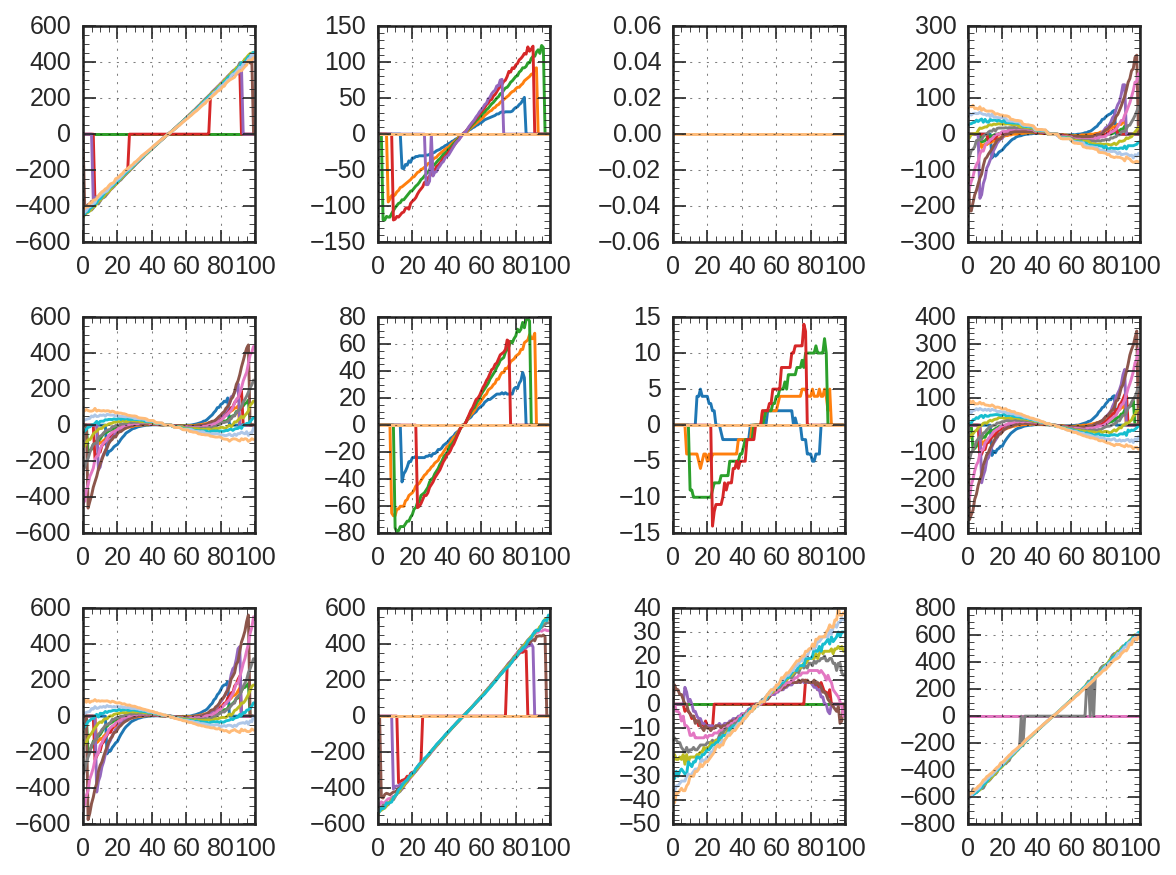

In [330]:
# w.r.t ME2
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(8,6), tight_layout=True)

for i in xrange(nlayers):
  for j in xrange(12):
    yy = patterns_match_me2_1[:,j,i]
    axs[i/4,i%4].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
plt.show()

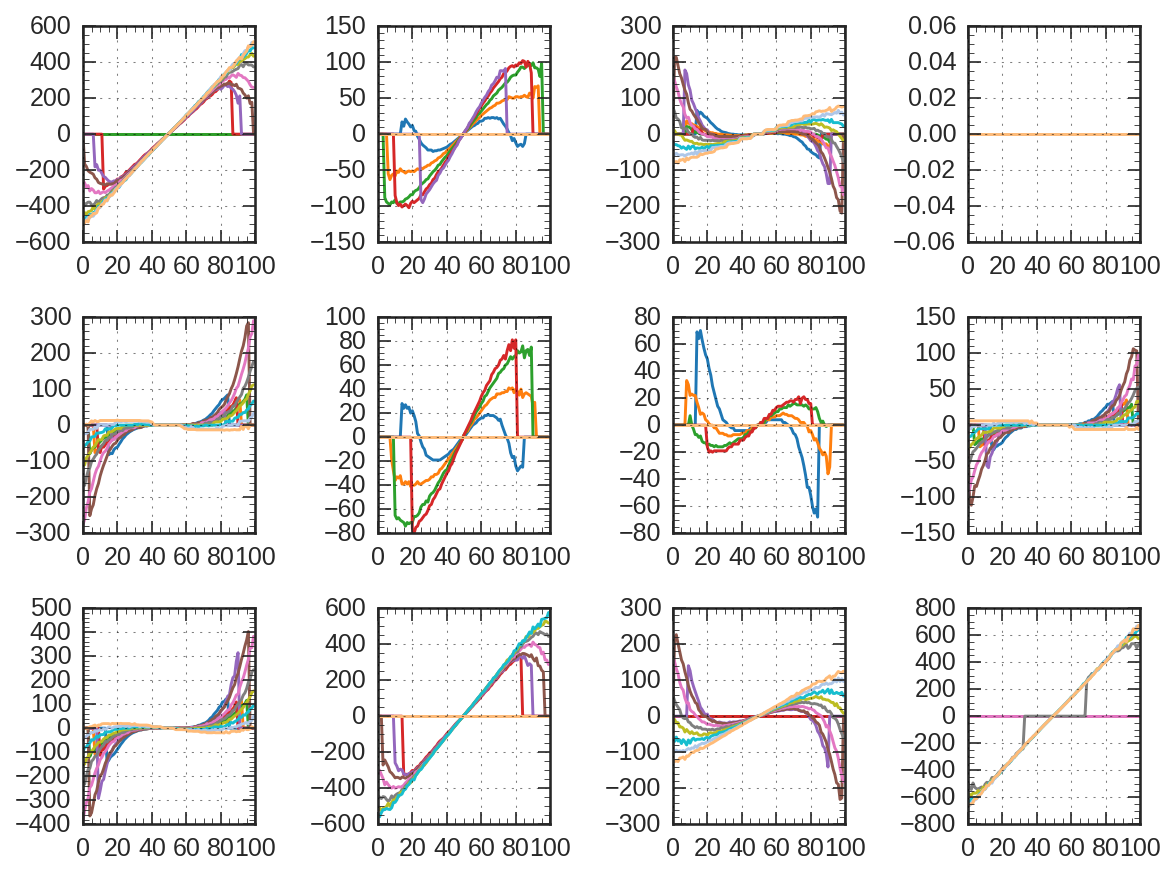

In [331]:
# w.r.t ME3
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(8,6), tight_layout=True)

for i in xrange(nlayers):
  for j in xrange(12):
    yy = patterns_match_me3_1[:,j,i]
    axs[i/4,i%4].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
plt.show()

In [332]:
# Smoothing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
#kernel = C(10000.0, (1e-2, 1e7)) * RBF(1.0, (1e-2, 1e2)) + W(1.0, (1e-5, 1e5))
#gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=10)

patterns_match_me2_2 = np.zeros(patterns_match_me2.shape, dtype=np.int32)
patterns_match_me3_2 = np.zeros(patterns_match_me3.shape, dtype=np.int32)

In [345]:
# ME1/1 w.r.t ME2, ME3

emtf_layer_me1 = 0
for i in xrange(2):  
  for j in xrange(12):
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    mask = None

    if j >= 3:  # ME1/1, valid for eta >= 1.5
      mask = (np.abs(yy) >= 1)
      if i == 0:
        if j == 3:
          mask[:13] = False
          mask[-13:] = False
        elif j == 4:
          mask[:24] = False
          mask[-24:] = False
        else:
          pass
      else:
        if j == 3:
          mask[:25] = False
          mask[-25:] = False
          mask[40:60+1] = False
        elif j in [4,5,6]:
          mask[:30] = False
          mask[-30:] = False
        elif j in [7,8]:
          mask[:25] = False
          mask[-25:] = False
        elif j in [9]:
          mask[:20] = False
          mask[-20:] = False
        else:
          pass

      #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
      kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
      gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=15)
      gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])
      
      if i == 0:
        patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
      else:
        patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

      params = gp.kernel_.get_params()
      params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    else:
      params = None
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), params

0,(1.2,1.3) None
0,(1.3,1.4) None
0,(1.4,1.5) None
0,(1.5,1.6) (103421.7273156602, 0.3972255882382747, 8.551946213941115)
0,(1.6,1.7) (82383.94149435681, 0.3613503318929942, 0.905102930083457)
0,(1.7,1.8) (83327.24160390632, 0.38859414202885795, 8.858136576635602)
0,(1.8,1.9) (119430.54063644532, 0.39816330390076987, 6.271428060980454)
0,(1.9,2.0) (136432.24274047304, 0.46053469875489184, 7.631875051247097)
0,(2.0,2.1) (180445.90735901546, 0.5470406236998494, 6.887401963578091)
0,(2.1,2.2) (249071.59148976434, 0.6375377716069223, 6.382497308406747)
0,(2.2,2.3) (218100.32466012976, 0.6170979189879083, 8.70539391517343)
0,(2.3,2.4) (236820.95412983678, 0.6583398956718447, 8.569666863436348)
1,(1.2,1.3) None
1,(1.3,1.4) None
1,(1.4,1.5) None


/home/jlow/L1MuonTrigger/PostProcessJobs/CMSSW_10_1_7/src/venv/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-2.27390105e-01,  6.71605445e-05, -2.28184906e-05]), 'nit': 13, 'funcalls': 60}
  " state: %s" % convergence_dict)


1,(1.5,1.6) (3000000.0000000023, 3.6305742549017763, 4.635829774922331)
1,(1.6,1.7) (320858.79540137964, 0.5895125878762123, 0.7198271795600554)
1,(1.7,1.8) (3000000.0000000023, 3.3856770607942845, 0.773254318693268)
1,(1.8,1.9) (258920.3357086475, 0.5560025039354884, 1.022840229986182)


/home/jlow/L1MuonTrigger/PostProcessJobs/CMSSW_10_1_7/src/venv/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-7.47952799e-05,  2.23272549e-04, -5.20059488e-05]), 'nit': 17, 'funcalls': 63}
  " state: %s" % convergence_dict)


1,(1.9,2.0) (704706.6406874525, 0.8582101202124458, 1.8209186875328907)
1,(2.0,2.1) (991289.7451812159, 0.9859239096253172, 1.4161743755032514)
1,(2.1,2.2) (876222.9568017467, 0.8933204481566798, 5.000418207191339)
1,(2.2,2.3) (232723.84880786663, 0.587950225272223, 17.61214812463168)
1,(2.3,2.4) (264027.19651188597, 0.6141598283356061, 20.44379043758048)


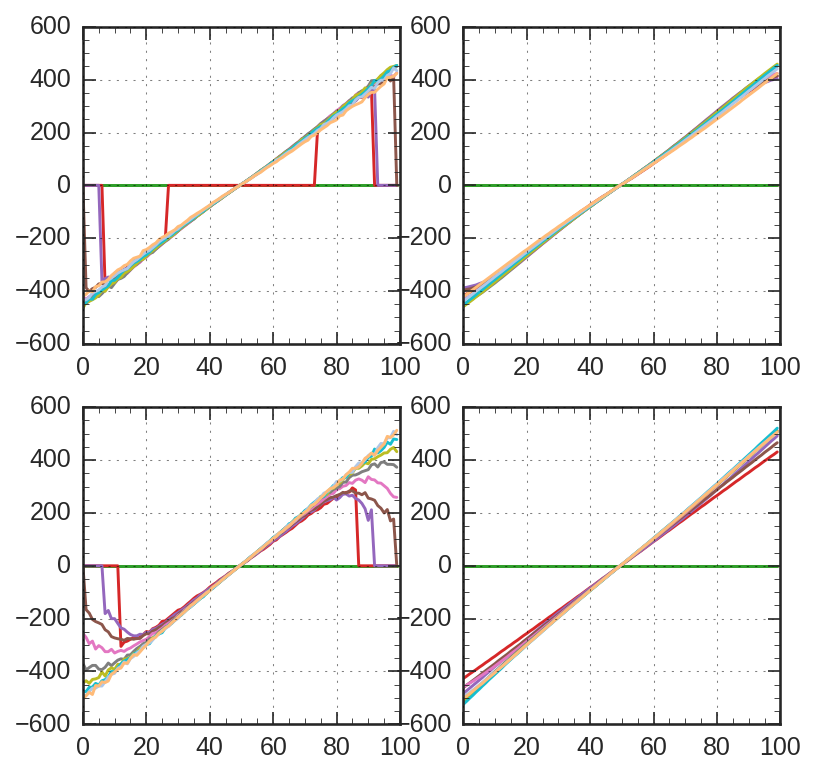

In [346]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [347]:
# ME0 w.r.t ME2, ME3

emtf_layer_me1 = 11
for i in xrange(2):  
  for j in xrange(12):
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    mask = None

    if j >= 8:  # ME0, valid for eta >= 2.0
      mask = (np.abs(yy) >= 1)
      if i == 0:
        if j == 8:
          mask[:22] = False
          mask[-22:] = False
        elif j == 9:
          mask[:15] = False
          mask[-15:] = False
        else:
          pass
      else:
        if j == 8:
          mask[:25] = False
          mask[-25:] = False
        elif j == 9:
          mask[:15] = False
          mask[-15:] = False
        else:
          pass

      #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
      kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
      gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=15)
      gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])
      
      if i == 0:
        patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
      else:
        patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

      params = gp.kernel_.get_params()
      params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    else:
      params = None
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), params

0,(1.2,1.3) None
0,(1.3,1.4) None
0,(1.4,1.5) None
0,(1.5,1.6) None
0,(1.6,1.7) None
0,(1.7,1.8) None
0,(1.8,1.9) None
0,(1.9,2.0) None


/home/jlow/L1MuonTrigger/PostProcessJobs/CMSSW_10_1_7/src/venv/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-3.67992725e-05, -2.33967598e-05,  9.10530757e-06]), 'nit': 15, 'funcalls': 57}
  " state: %s" % convergence_dict)


0,(2.0,2.1) (153788.05934582258, 0.37781075302547984, 1.6314625876414068)
0,(2.1,2.2) (283805.6630409253, 0.49287186538708805, 4.562008885441366)
0,(2.2,2.3) (364945.22199092887, 0.5774839569419365, 11.25090581601286)
0,(2.3,2.4) (583640.9978817814, 0.7237300195289789, 22.310535640957877)
1,(1.2,1.3) None
1,(1.3,1.4) None
1,(1.4,1.5) None
1,(1.5,1.6) None
1,(1.6,1.7) None
1,(1.7,1.8) None
1,(1.8,1.9) None
1,(1.9,2.0) None
1,(2.0,2.1) (335042.86008063075, 0.4966864009121705, 2.3217219996046876)
1,(2.1,2.2) (306241.6688296369, 0.49588618080192387, 10.796640948466706)
1,(2.2,2.3) (347305.48629011033, 0.5394302962741099, 22.624556339126908)
1,(2.3,2.4) (479026.8040599511, 0.6300199470601943, 27.488106622372786)


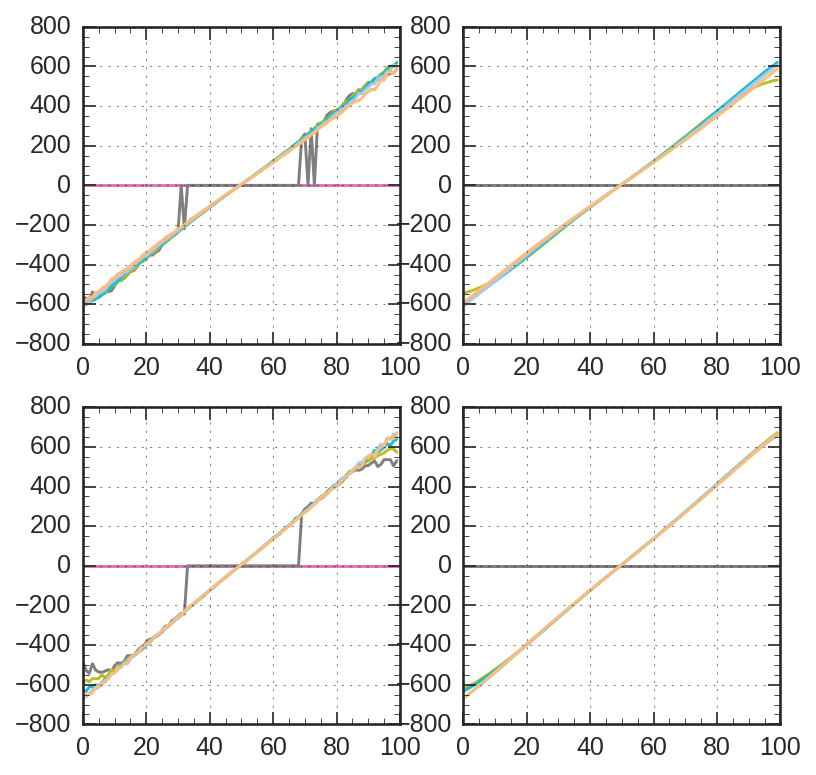

In [348]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [356]:
# GE1/1 w.r.t ME2, ME3

emtf_layer_me1 = 9
for i in xrange(2):  
  for j in xrange(12):
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    mask = None

    if 3 <= j <= 9:  # GE1/1, valid for 1.5 <= eta <= 2.2
      mask = (np.abs(yy) >= 1)
      if i == 0:
        if j == 3:
          pass
        elif j in [4,5,6]:
          mask[:20] = False
          mask[-20:] = False
        elif j in [7,8]:
          mask[:10] = False
          mask[-10:] = False
        else:
          pass
      else:
        if j == 3:
          pass
        elif j in [4,5,6]:
          mask[:20] = False
          mask[-20:] = False
        elif j in [7,8]:
          mask[:10] = False
          mask[-10:] = False
        else:
          pass

      #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
      kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
      gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=15)
      gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])
      
      if i == 0:
        patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
      else:
        patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

      params = gp.kernel_.get_params()
      params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    else:
      params = None
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), params

0,(1.2,1.3) None
0,(1.3,1.4) None
0,(1.4,1.5) None
0,(1.5,1.6) (60358.00823705829, 0.23231499000134426, 16.648279881038633)
0,(1.6,1.7) (100359.10420334869, 0.3415809696903754, 1.2375995753316997)
0,(1.7,1.8) (121533.25321378939, 0.3778471557612791, 1.311117996740414)


/home/jlow/L1MuonTrigger/PostProcessJobs/CMSSW_10_1_7/src/venv/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-1.53760703e+00,  5.21155804e-05,  2.61677148e-04]), 'nit': 15, 'funcalls': 100}
  " state: %s" % convergence_dict)


0,(1.8,1.9) (128457.5448196182, 0.3843175509699699, 0.6898725678295979)
0,(1.9,2.0) (197790.30914207918, 0.47296748614451906, 3.616493853547874)
0,(2.0,2.1) (259135.57659828724, 0.5268423974289861, 3.9226262341225677)
0,(2.1,2.2) (252179.21921793855, 0.45485379410933474, 20.117764423168424)
0,(2.2,2.3) None
0,(2.3,2.4) None
1,(1.2,1.3) None
1,(1.3,1.4) None
1,(1.4,1.5) None
1,(1.5,1.6) (48910.99895327275, 0.20876100140289122, 5.205545448208404)
1,(1.6,1.7) (66332.81924481112, 0.28767627603673174, 3.2266894075809924)
1,(1.7,1.8) (71564.09475346183, 0.325139678287304, 2.408738225996229)
1,(1.8,1.9) (87440.98258646797, 0.33232156308816296, 2.661832285612441)
1,(1.9,2.0) (118921.90935660375, 0.38625284116495123, 6.388931827681192)
1,(2.0,2.1) (176622.96124626225, 0.45428646639875836, 8.34394338521983)
1,(2.1,2.2) (187260.38083462673, 0.4234271479118115, 38.3282836180523)
1,(2.2,2.3) None
1,(2.3,2.4) None


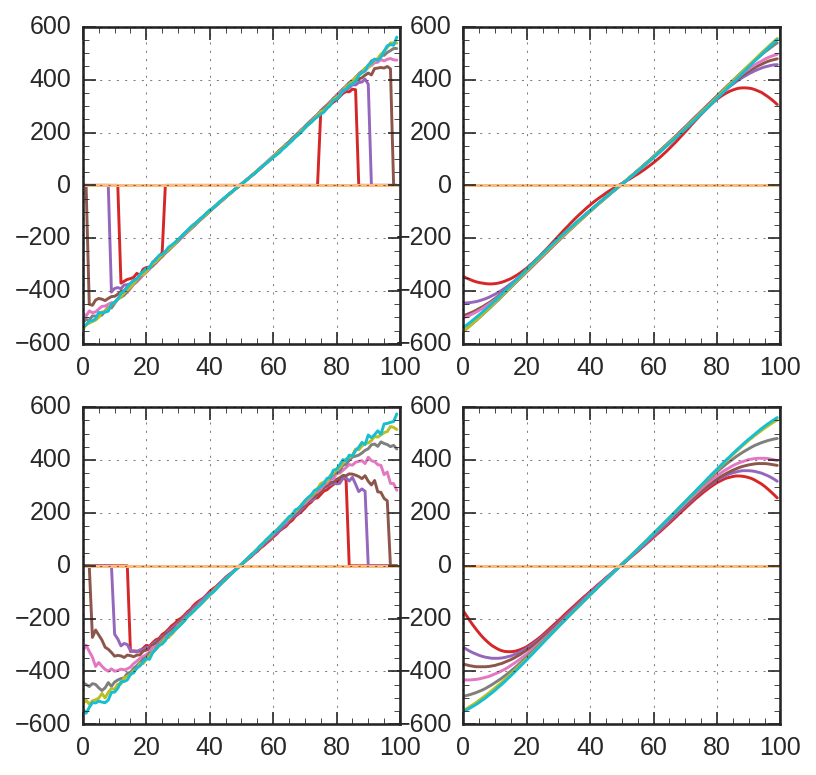

In [357]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [349]:
# ME1/2 w.r.t ME2, ME3

emtf_layer_me1 = 1
for i in xrange(2):  
  for j in xrange(12):
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    mask = None

    if j <= 4:  # ME1/2, valid for eta <= 1.6
      mask = (np.abs(yy) >= 1)
      if i == 0:
        if j == 0:
          mask[:32] = False
          mask[-32:] = False
        elif j in [1,2,3]:
          mask[:17] = False
          mask[-17:] = False
        elif j == 4:
          mask[:32] = False
          mask[-32:] = False
        else:
          pass
      else:
        if j == 0:
          mask[:37] = False
          mask[-37:] = False
        elif j in [1,2,3]:
          mask[:22] = False
          mask[-22:] = False
        elif j == 4:
          mask[:32] = False
          mask[-32:] = False
        else:
          pass

      #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
      kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
      gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=15)
      gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])
      
      if i == 0:
        patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
      else:
        patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

      params = gp.kernel_.get_params()
      params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    else:
      params = None
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), params

0,(1.2,1.3) (1273.0080019221593, 0.41881236573064556, 0.11846880833656442)


/home/jlow/L1MuonTrigger/PostProcessJobs/CMSSW_10_1_7/src/venv/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-2.24857358e-05,  1.16534958e-04, -1.14835166e-04]), 'nit': 10, 'funcalls': 53}
  " state: %s" % convergence_dict)


0,(1.3,1.4) (16242.601084873702, 0.6690790182146061, 0.27662898350271914)
0,(1.4,1.5) (8500.15386282528, 0.4162052869371966, 0.2801085218618558)
0,(1.5,1.6) (16477.783713990346, 0.4384713031006724, 1.1343720818008034)
0,(1.6,1.7) (11031.51249789085, 0.3159623958363197, 0.6872284490486176)
0,(1.7,1.8) None
0,(1.8,1.9) None
0,(1.9,2.0) None
0,(2.0,2.1) None
0,(2.1,2.2) None
0,(2.2,2.3) None
0,(2.3,2.4) None
1,(1.2,1.3) (510.11910426014765, 0.20855754932391873, 0.185205381692469)
1,(1.3,1.4) (2015.3845643210732, 0.3682155242324686, 0.3261931100347831)
1,(1.4,1.5) (12136.570365729154, 0.7132999856394148, 0.3209961707456946)
1,(1.5,1.6) (15735.874024850837, 0.6598092446238306, 0.37321794362009325)
1,(1.6,1.7) (38522.44939823415, 0.8769648892763607, 0.617258500727825)
1,(1.7,1.8) None
1,(1.8,1.9) None
1,(1.9,2.0) None
1,(2.0,2.1) None
1,(2.1,2.2) None
1,(2.2,2.3) None
1,(2.3,2.4) None


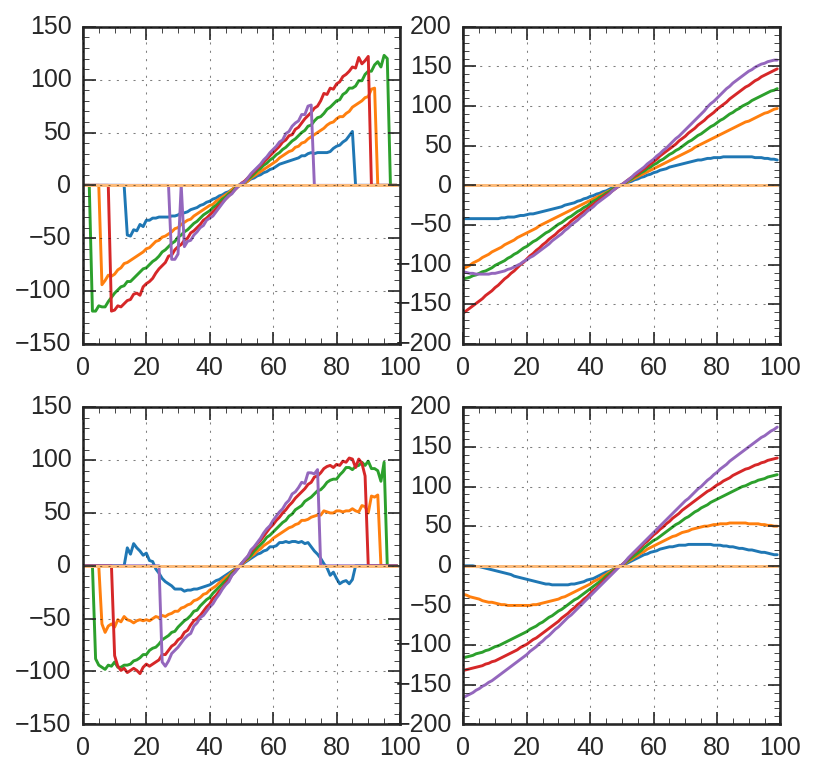

In [350]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

### Find pattern windows

In [ ]:
%%time

_get_emtf_phi = lambda x: x[1]

patterns_phi = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)
patterns_match = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)
for ind in np.ndindex(patterns_phi.shape):
  patterns_phi[ind] = []
  patterns_match[ind] = []

# Loop over part and hits
# - part is (part_invpt, part_eta, part_phi, zone, mode)
# - hits is a collection of (emtf_layer, emtf_phi, old_emtf_phi)

print("Processing events ...")

for part, hits in zip(out_part, out_hits):
  (part_invpt, part_eta, part_phi, zone, mode) = part
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    if hit[0] != -99:  # invalid
      amap.setdefault(hit[0], []).append(hit)
      
  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer

  # Find hit phi at the key station
  key_hit_phi = None
  if 2 in amap:    # use ME2
    key_hit_phi = _get_emtf_phi(amap[2])
  elif 3 in amap:  # alternatively, use ME3
    key_hit_phi = _get_emtf_phi(amap[3])
    key_hit_phi -= patterns_match_pre_1[ipt50, ieta13, 3]
    key_hit_phi += patterns_match_pre_1[ipt50, ieta13, 2]
  elif 4 in amap:  # alternatively, use ME4
    key_hit_phi = _get_emtf_phi(amap[4])
    key_hit_phi -= patterns_match_pre_1[ipt50, ieta13, 4]
    key_hit_phi += patterns_match_pre_1[ipt50, ieta13, 2]

  if key_hit_phi is None:
    continue
    
  #lut = np.array([2, 2, 0, 0, 0, 0, 2, 3, 4, 0, 2, 0], dtype=np.int32)
  #lut = find_emtf_layer_partner.lut
  
  # Make pair of hits
  for k, v in amap.iteritems():
    emtf_layer = k
    hit_phi1 = _get_emtf_phi(v)
    patterns_phi[ipt, zone, emtf_layer].append(hit_phi1 - key_hit_phi)
    
    emtf_layer_partner = find_emtf_layer_partner(emtf_layer, zone)
    
    if emtf_layer_partner in amap:
      hit_phi2 = _get_emtf_phi(amap[emtf_layer_partner])
      patterns_match[ipt, zone, emtf_layer].append(hit_phi1 - hit_phi2)
  continue  # end loop over part and hits

In [ ]:
valid_layers = np.zeros(patterns_phi.shape, dtype=np.bool)
valid_layers[:, 0, [0,2,3,4,7,8,10,11]]   = True
valid_layers[:, 1, [0,2,3,4,7,8,9,10,11]] = True
valid_layers[:, 2, [0,2,3,4,7,8,9,10]]    = True
valid_layers[:, 3, [0,2,3,4,7,8,9,10]]    = True
valid_layers[:, 4, [0,1,2,3,4,7,8,9,10]]  = True
valid_layers[:, 5, [1,2,3,4,5,6,7,8]]     = True

# Histogram
patterns_phi_1 = np.zeros(patterns_phi.shape + (63,), dtype=np.int32)  # make 63 bins, bin 31 is the highest pT
for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    #print ind, np.percentile(patterns_phi[ind], [5,50,95], overwrite_input=True)
    patterns_phi_1[ind], _ = np.histogram(patterns_phi[ind], bins=63, range=(-0.5*63*superstrip_size,0.5*63*superstrip_size,))

In [ ]:
fig, axs = plt.subplots(ncols=6, nrows=9, figsize=(8,8./6*9), tight_layout=True, sharex=True, sharey=True)

for i in xrange(9):
  for j in xrange(6):
    img = patterns_phi_1[i,j,:]
    axs[i,j].imshow(img, origin='lower', interpolation='nearest', aspect='auto')
    axs[i,j].axis('off')
    
plt.show()

In [ ]:
patterns_phi_2 = np.zeros(patterns_phi.shape + (3,), dtype=np.int32)
for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    #print ind, np.percentile(patterns_phi[ind], [5,50,95], overwrite_input=True)
    
    x = patterns_phi_1[ind].copy().astype(np.int64)
    #norm = x.sum()
    norm = np.sqrt(np.square(x).sum())
    assert(np.isfinite(norm).all())
    x = np.true_divide(x, norm)
    x[np.isnan(x)] = 0
    
    try:
      #y = np.where(x > 0.01)[0]
      y = np.where(x > 0.05)[0]
      y = y[0] - 31, y[-1] - 31  # offset by 31
    except:
      y = 0, 0
    
    z = np.percentile(patterns_phi[ind], [2.5,50,97.5], overwrite_input=True)
    z = np.round(np.true_divide(z, superstrip_size))
    print ind, y, z
    
    patterns_phi_2[ind] = y[0], z[1], y[1]

In [ ]:
fig, axs = plt.subplots(ncols=6, nrows=9, figsize=(8,8./6*9), tight_layout=True, sharex=True, sharey=True)

for i in xrange(9):
  for j in xrange(6):
    img = np.zeros((nlayers, 63), dtype=np.float32)
    for k in xrange(nlayers):
      x0, x1 = patterns_phi_2[i,j,k,0] + 31, patterns_phi_2[i,j,k,2] + 31  # offset by 31
      img[k, slice(x0,x1+1)] = 1

    axs[i,j].imshow(img, origin='lower', interpolation='none', aspect='auto')
    axs[i,j].axis('off')
    
plt.show()

In [ ]:
patterns_match_1 = np.zeros(patterns_match.shape + (3,), dtype=np.int32)

for ind in np.ndindex(patterns_match.shape):
  if valid_layers[ind]:
    patterns_match_1[ind] = np.percentile(patterns_match[ind], [5, 50, 95], overwrite_input=True)
    print ind, patterns_match_1[ind]

In [ ]:
outfile = 'histos_tb.npz'
np.savez_compressed(outfile, patterns_phi=patterns_phi_2, patterns_match=patterns_match_1)

In [ ]:
loaded = np.load('histos_tb.npz')
print loaded['patterns_phi'].shape
print loaded['patterns_match'].shape

In [ ]:
print loaded['patterns_phi'][:,1,:5]
print loaded['patterns_match'][:,1,:5]